
## Before we get the data and start exploring it, let's import all required libraries .

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')  

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

## My Foursquare Credentials

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = '2IJRZASUBGTFIHAVUX0E2RRBABXMOVM2KAQ0SKEL54INTQK3' # your Foursquare ID
CLIENT_SECRET = 'BE0EL00EMWHNV22IXMFZIJTVDS0YIF35PNUBAWMPH4NGKPRS' # your Foursquare Secret
VERSION = '20200801' # Foursquare API version

## Defining the functions we are going to use later in this project

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Now let's use the above codes to get our initial NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York.  

## Initial Data Analysis

Now let's analyze our initial data. 

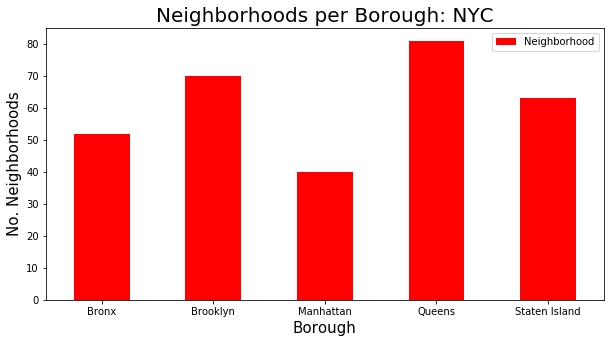

In [6]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

##### queens has most neighborhoods

## Let's analyze further and see how many Korean restaurants there are in each neighborhood and borough. After it, graph the results.

In [7]:

# prepare neighborhood list that contains korean restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_restaurants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(ny_data),')','Korean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(korean_restaurants)))
    print(row)
    for resturant_detail in korean_restaurants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Korean Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Korean Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Korean Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Korean Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Korean Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Korean Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Korean Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Korean Restaurants in Norwood, Bronx:0
['Bronx', '

In [8]:
#korean_rest_ny.to_csv('korean_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
korean_rest_ny.to_csv('korean_rest_ny_tocsv1.csv') 

In [9]:
korean_ny = pd.read_csv('korean_rest_ny_tocsv1.csv')
korean_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law
1,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill
2,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory
3,Brooklyn,Downtown,5b01ecd28cdedf00245af923,BonChon Chicken
4,Brooklyn,North Side,59c295349b04732c1d51aa52,Kimbap Lab


In [10]:
korean_rest_ny.shape

(58, 4)

We have 58 Korean Restaurants across the New York City. 

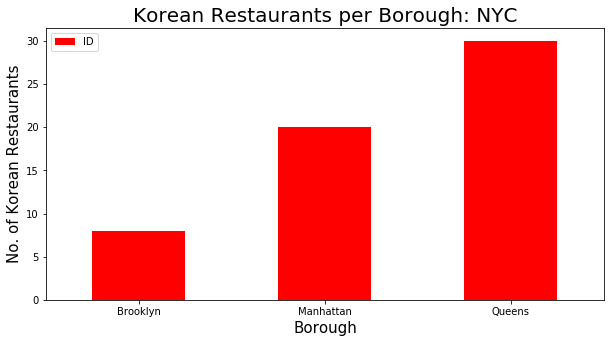

In [11]:
korean_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Korean Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Korean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

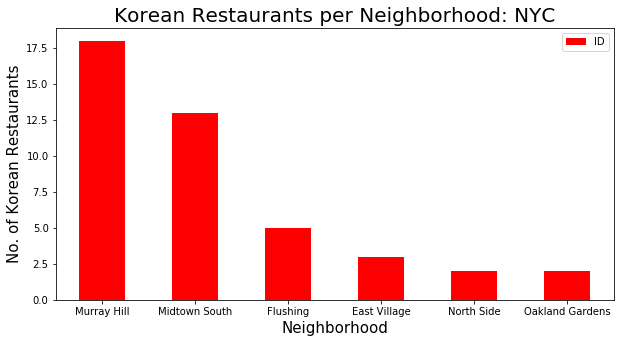

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Korean Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Korean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [13]:
korean_rest_ny[korean_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
25,Queens,Murray Hill,4b830e44f964a520ebf430e3,Hahm Ji Bach - 함지박
26,Queens,Murray Hill,4b8f0931f964a520d04533e3,Mapo BBQ
27,Queens,Murray Hill,4baeabe6f964a52037cd3be3,Kum Sung Chik Naengmyun
28,Queens,Murray Hill,4c7ad3dda86837048bee144d,Geo Si Gi Restaurant
29,Queens,Murray Hill,56db53cc498eed9b68621019,SGD Tofu House & BBQ
30,Queens,Murray Hill,5518a1a8498e4c7fe6268b88,Jongro BBQ
31,Queens,Murray Hill,5590598a498eb1c3f975b6a6,Mr. Tofu
32,Queens,Murray Hill,4ad3bfabf964a52016e620e3,Han Joo
33,Queens,Murray Hill,4ca67385b7106dcb6e3b5ea5,Bonjuk Korean Traditional Porridge Restaurant
34,Queens,Murray Hill,58756dc845c3ed5546c88309,Sodam


So the Murray Hill in Queens has the highest number of Korean Restaurants with a total count of 18.

Now we will get the ranking of each restaurant for further analysis.

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
korean_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f32d1a77ce56f2a2fd2098e'}, 'response': {'venue': {'id': '4c9d5c0303133704a96f5ed5', 'name': 'Cafe At Your Mother-in-Law', 'contact': {'phone': '7189424088', 'formattedPhone': '(718) 942-4088', 'twitter': 'cafeaymil_ny'}, 'location': {'address': '3071 Brighton 4th St', 'lat': 40.57757524231774, 'lng': -73.96344895612154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57757524231774, 'lng': -73.96344895612154}, {'label': 'entrance', 'lat': 40.577515, 'lng': -73.963289}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3071 Brighton 4th St', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-at-your-motherinlaw/4c9d5c0303133704a96f5ed5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korea

In [ ]:
korean_rest_stats_ny.to_csv('korean_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file 

In [ ]:
korean_rest_stats_ny.shape

We got statistics for all 50 Korean Restaurants in New York city. 

Let's check what values we have in our DataFrame

In [ ]:
korean_rest_stats_ny.info()

We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [ ]:
korean_rest_stats_ny['Likes'] = korean_rest_stats_ny['Likes'].astype('float64')
korean_rest_stats_ny['Tips'] = korean_rest_stats_ny['Tips'].astype('float64')
korean_rest_stats_ny.info()

## Now when the data types look correct, let's continue our analysis.

In [ ]:
korean_rest_stats_ny.describe()

In [ ]:
# Resturant with maximum Likes
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# Resturant with maximum Ratings
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]

In [ ]:
# Resturant with maximum Tips
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

## Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [ ]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Above are the top neighborhoods with the highest average ratings of Korean restaurants.

In [ ]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Similarly these are the average ratings of Korean Restaurants for each Borough

## Let's visualize the results

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Korean Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal to 7.0 to visualize on a map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

We will join this Dataset to original New York data to get longitude and latitude

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Now we will show this data on a map

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)